# 目的
- チョコボールパッケージ画像の前処理コードのテスト

In [1]:
import os
import cv2
import numpy as np

import math
import pandas as pd
from scipy import stats
from scipy import ndimage

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
## 特定の色のフィルタ（ROI）を作成する
def getColorROI(frame, h_range=(20, 200), saturation = (128, 255), value=(0, 255)):
    """
    BGR画像を入力し、特定の色のフィルタを作成する
    色の指定はHSV色空間
    Args:
      frame : イメージのarray(0~255, BGR_color_channel)
      h_range : tuple of h_range (min_range, max_range)
      saturation : saturation (0~255)
    Returns:
      roi : 0or1の行列（[height, width]）
    """
    # BGRイメージをHSV表現に変換する
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV_FULL)
    frame_h = frame_hsv[:,:,0] # 色相
    frame_s = frame_hsv[:,:,1] # 彩度
    frame_v = frame_hsv[:,:,2] # 明度
    # ROIの作成
    ## opencvで取り込んだ画像データがuint8なので、ROIマスクも同じ型にする
    roi = np.zeros_like(frame_h, dtype=np.uint8)
    min_range_h = h_range[0]
    max_range_h = h_range[1]
    roi[( ((frame_h>min_range_h)&(frame_h<=max_range_h))
              | ((frame_h+255>min_range_h)&(frame_h+255<=max_range_h))
              ) & ((frame_s>=saturation[0])&(frame_s<=saturation[1])) & ((frame_v>=value[0])&(frame_v<=value[1]))] = 1
    return roi

In [3]:
# エッジを検出するための関数
def getEdge(img, axis=0, n_filter=5, right=False):
    """
    img:2値化画像
    axis:探索方向
    n_filter:足し合わせるフィルタのサイズ
    right:右側からの畳み込みにするか否かのフラグ
    """
    if axis==1:
        mat = img.copy().transpose(1,0)
    else:
        mat = img.copy()
    if right:
        mat = mat[:,::-1]
    size = mat.shape[0]
    
    def firstPoint(arr, n):
        conv = np.convolve(arr, np.ones(n), mode='valid')
        try:
            idx = list(conv).index(n)
        except ValueError:
            idx = arr.shape[0]-1
        return idx
    
    edge = list(map(lambda i: firstPoint(mat[i], n_filter), np.arange(size)))
    if right:
        edge = list(map(lambda x:(mat.shape[1]-1)-x, edge))
    return edge

# 画像データの取り込み

In [4]:
# 画像の読み込み
im_dir = '../../data/packages'
im_name = '20180429_191.png'
org_img = cv2.imread(os.path.join(im_dir, im_name))
img = org_img[10:-10,10:-10,:] # 画像の端はノイズが載っていることがあるのでトリミングする

# パッケージ正面を切り抜く
## 茶色と黄色のフィルタを作成

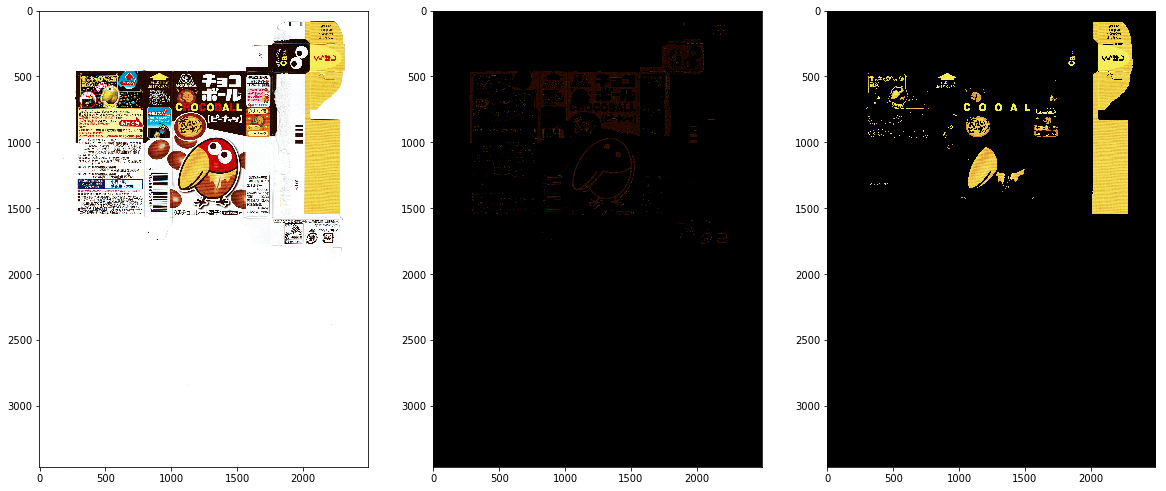

In [5]:
# 茶色領域を認識するために茶色のフィルタを作成
roi_brown = getColorROI(frame=img,
                        h_range=(0, 80), saturation=(100, 255), value=(0, 80))
# 黄色領域を認識するために黄色のフィルタを作成
roi_yellow = getColorROI(frame=img, 
                         h_range=(20, 80), saturation=(100, 255), value=(200, 255))

# ROIを3チャネルに拡張
roi3_b = np.concatenate(
    (roi_brown[:,:,np.newaxis], roi_brown[:,:,np.newaxis], roi_brown[:,:,np.newaxis])
    , axis=2)
# ROIをかぶせる
img_masked_b = img * roi3_b
# ROIを3チャネルに拡張
roi3_y = np.concatenate(
    (roi_yellow[:,:,np.newaxis], roi_yellow[:,:,np.newaxis], roi_yellow[:,:,np.newaxis])
    , axis=2)
# ROIをかぶせる
img_masked_y = img * roi3_y

fig = plt.figure(figsize=(20, 10))
ax = fig.subplots(1,3)
show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax[0].imshow(show_img)
show_img = cv2.cvtColor(img_masked_b, cv2.COLOR_BGR2RGB)
ax[1].imshow(show_img)
show_img = cv2.cvtColor(img_masked_y, cv2.COLOR_BGR2RGB)
ax[2].imshow(show_img)

## 回転補正

In [6]:
# 上から茶色までの距離
edge_up_b = getEdge(roi_brown, axis=1, right=False)

In [7]:
# 上辺を水平になるように回転する
# 全体の3分の１〜半分までの茶色距離を水平にするようにする
rang = (int(roi_brown.shape[1]*0.4), int(roi_brown.shape[1]*0.5))
## 横軸の座標
x = np.arange(0, roi_brown.shape[1])
## 座標
points = np.array([x, edge_up_b])
points = points[:, rang[0]:rang[1]]

In [8]:
# 単回帰
reg = stats.linregress(points[0,:], points[1,:])
rad = math.atan(reg.slope)
print('rotate angle(degree):', rad*180/math.pi)

rotate angle(degree): 0.11025154198656052


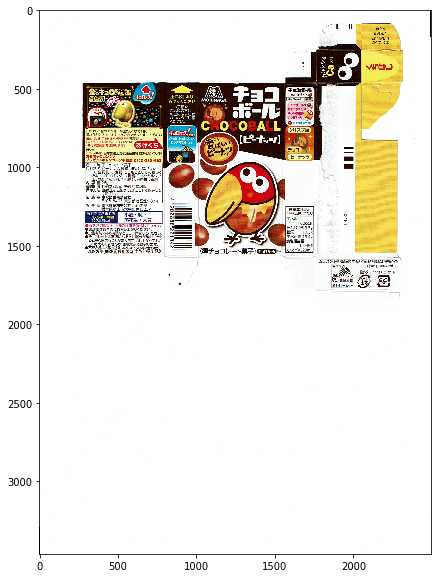

In [9]:
# 回転
rot_img = ndimage.rotate(img, rad*180/math.pi, reshape=False)

show_img = cv2.cvtColor(rot_img, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(10, 10))
ax = fig.subplots(1,1)
ax.imshow(show_img)

## 画像領域のトリミング
- まずは無駄な余白を削除

In [10]:
# パッケージ部分のトリミングする
# 茶色領域を認識するために茶色のフィルタを作成
roi_brown = getColorROI(frame=rot_img,
                        h_range=(0, 80), saturation=(100, 255), value=(0, 80))
# 黄色領域を認識するために茶色のフィルタを作成
roi_yellow = getColorROI(frame=rot_img, 
                         h_range=(20, 80), saturation=(100, 255), value=(200, 255))


edge_left = getEdge(roi_brown, axis=0) # 左から茶色まで
edge_right = getEdge(roi_yellow, axis=0, right=True) # 右から黄色まで
edge_top = getEdge(roi_yellow, axis=1) # 上から黄色まで
edge_bottom = getEdge(roi_brown, axis=1, right=True) # 下から茶色まで

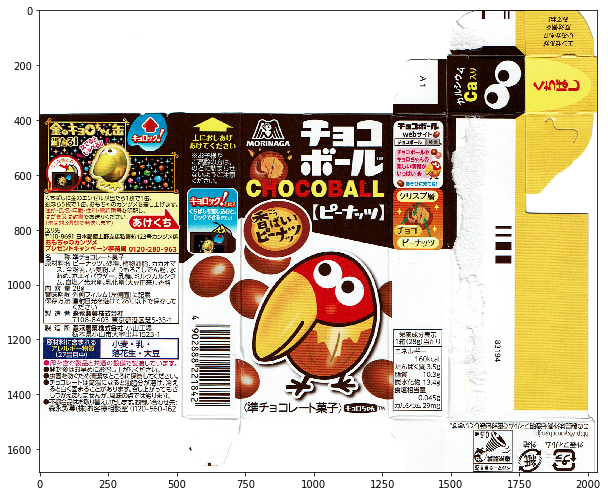

In [11]:
width_lim = (np.min(edge_top),np.max(edge_bottom))
height_lim = (np.min(edge_left), np.max(edge_right))
trim_img = rot_img[width_lim[0]:width_lim[1], height_lim[0]:height_lim[1]]

show_img = cv2.cvtColor(trim_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(show_img)

## パッケージ正面の切り抜き
- スキャン画像のサイズ、パッケージ自体の大きさは同じだと仮定し、規定量をトリムする

In [12]:
# 茶色領域を認識するために茶色のフィルタを作成
roi_brown = getColorROI(frame=trim_img,
                        h_range=(0, 80), saturation=(100, 255), value=(0, 80))
# 上から茶色までの距離
edge_up_b = getEdge(roi_brown, axis=1, right=False)

# 上の茶色部分を規準にトリミングする
# 全体の6割分までの茶色距離の中央値でトリムする
rang = (0, int(roi_brown.shape[1]*0.6))
## 座標
points = edge_up_b[rang[0]:rang[1]]
trim_point = int(np.median(points))
trim_img = trim_img[trim_point:]


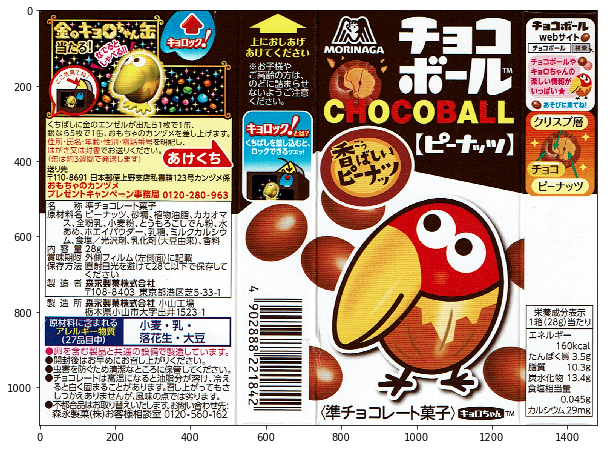

In [13]:
# 原点を規準に規定量をトリムする(スキャンする大きさは一定だと仮定する)
package_img = trim_img[:1100, :1480]

cv2.imwrite(os.path.join(im_dir, 'trimmed_packages', im_name),package_img)

show_img = cv2.cvtColor(package_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(show_img)